In [262]:
import numpy as np
import random as rd
import math

import matplotlib.pyplot as plt
import networkx as nx
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import src.privacy_ml as ml #import split_horizontally, split_into_random_subsets, stepForward, stepForwardMono, stepForward_2
import src.logistic_reg as lr #import cost
import src.util as util

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [251]:
num_agents = 10
seed = 42

T = 250
mu = 0.1

data = "classification"

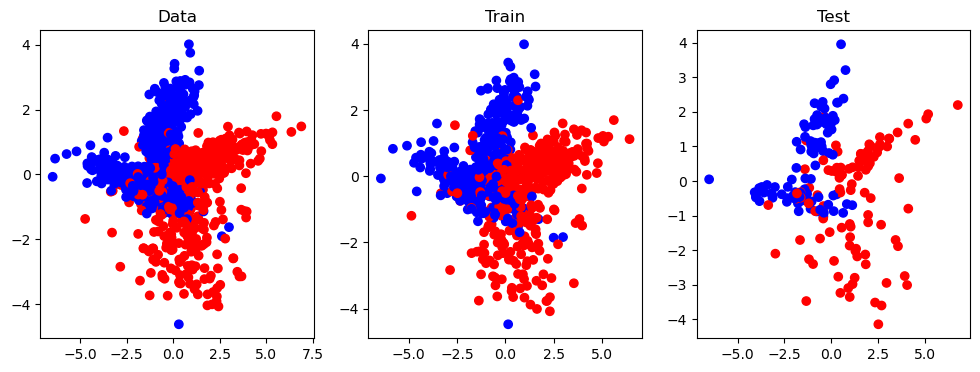

In [259]:
if data == "classification":
    X, Y = make_classification(n_samples=1000, n_classes=2, random_state=seed, flip_y=0.05)
elif data == "moons":
    X, Y = make_moons(n_samples=1000, noise=0.2, random_state=seed)


Y_formated = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=0.2)

pca = PCA(n_components=2)


if data == "classification":
    X_pca = pca.fit_transform(X)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.fit_transform(X_test)
    plt.figure(figsize=(12,4))
    plt.subplot(1, 3, 1)
    plt.scatter(X_pca[:,0], X_pca[:,1], c=['blue' if y== 0 else 'red' for y in Y])
    plt.title("Data")
    plt.subplot(1, 3, 2)
    plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=['blue' if y== 0 else 'red' for y in Y_train])
    plt.title("Train")
    plt.subplot(1, 3, 3)
    plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=['blue' if y== 0 else 'red' for y in Y_test])
    plt.title("Test")
    plt.show()

elif data == "moons":
    plt.figure(figsize=(12,4))
    plt.subplot(1, 3, 1)
    plt.scatter(X[:,0], X[:,1], c=['blue' if y== 0 else 'red' for y in Y])
    plt.title("Data")
    plt.subplot(1, 3, 2)
    plt.scatter(X_train[:,0], X_train[:,1], c=['blue' if y== 0 else 'red' for y in Y_train])
    plt.title("Train")
    plt.subplot(1, 3, 3)
    plt.scatter(X_test[:,0], X_test[:,1], c=['blue' if y== 0 else 'red' for y in Y_test])
    plt.title("Test")
    plt.show()


On va trier les points par rapport à leur abscisse, pour simuler un effet de proximité entre les points, et utiliser cette proximité pour délimiter les différents agents.

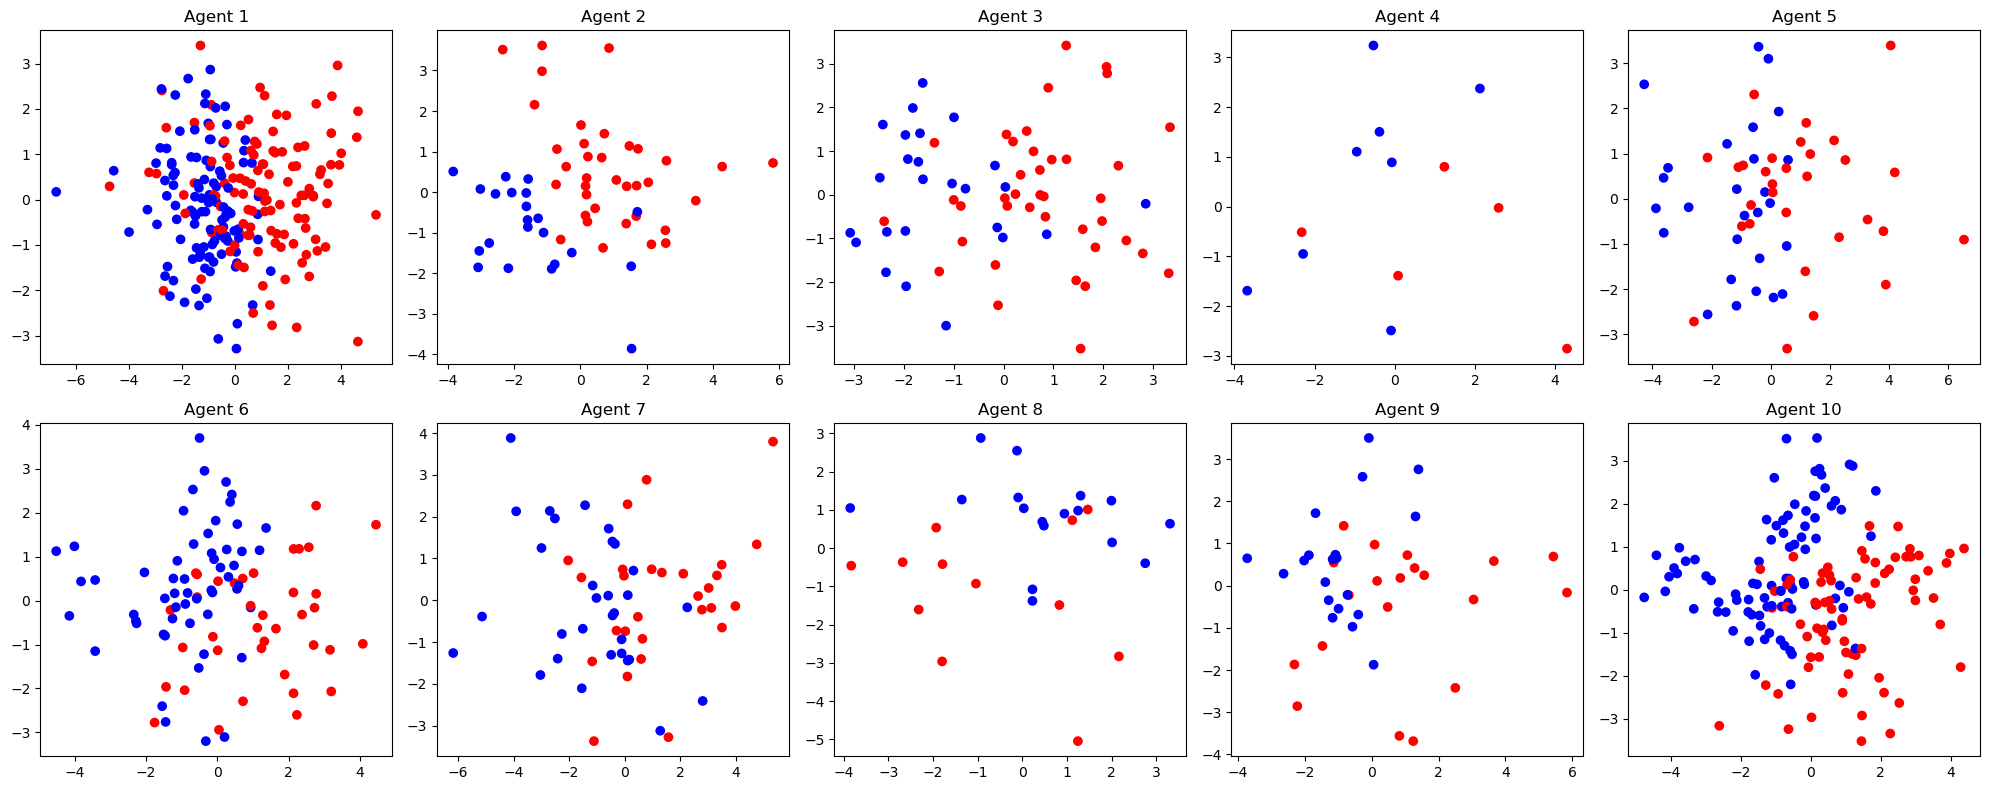

In [260]:

X_agent, Y_agent = ml.split_into_random_subsets(X_train, Y_train, random_state=seed)
#X_agent, Y_agent = ml.split_horizontally(X_train, Y_train)

fig, axes = plt.subplots(nrows=2, ncols=int(num_agents/2), figsize=(20, 8))

if data == "classification":
    for i in range(num_agents):
        X_agent_pca = pca.fit_transform(X_agent[i])
        row = i // (num_agents // 2)
        col = i % (num_agents // 2)
        colors = ['blue' if y== 0 else 'red' for y in Y_agent[i]]
        axes[row, col].scatter(X_agent_pca[:,0], X_agent_pca[:,1], c=colors)
        axes[row, col].set_title(f'Agent {i+1}')
elif data == "moons":
    for i in range(num_agents):
        row = i // (num_agents // 2)
        col = i % (num_agents // 2)
        colors = ['blue' if y== 0 else 'red' for y in Y_agent[i]]
        axes[row, col].scatter(X_agent[i][:,0], X_agent[i][:,1], c=colors)
        axes[row, col].set_title(f'Agent {i+1}')

plt.tight_layout()
plt.show()

In [216]:
if data == "moons":
    X_agent_augmented = []
    for i in range(num_agents):
        X_agent_augmented.append(np.concatenate([X_agent[i], X_agent[i]**2, X_agent[i]**3, X_agent[i]**4, X_agent[i]**5], axis=1))
    X_test_augmented = np.concatenate([X_test, X_test**2, X_test**3, X_test**4, X_test**5], axis=1)
    X_train_augmented = np.concatenate([X_train, X_train**2, X_train**3, X_train**4, X_train**5], axis=1)
elif data == "classification":
    X_agent_augmented = X_agent
    X_test_augmented = X_test
    X_train_augmented = X_train

In [217]:
np.random.seed(seed)

maxSize = np.max([x.shape[0] for x in X_agent])
minSize = np.min([x.shape[0] for x in X_agent])
meanSize = np.mean([x.shape[0] for x in X_agent])

G, D = ml.construct_G_D(num_agents)

c = np.zeros(num_agents)
for i in range(num_agents):
    c[i] = X_agent[i].shape[0]/maxSize

print(f"Max: {maxSize}")
print(f"Min: {minSize}")
print(f"Mean: {meanSize}")
print(f"G: {G}")
print(f"D: {D}")
print(f"c: {c}")

Max: 225
Min: 13
Mean: 80.0
G: [[0.         0.37454012 0.95071431 0.73199394 0.         0.
  0.         0.         0.         0.        ]
 [0.37454012 0.         0.59865848 0.15601864 0.15599452 0.
  0.         0.         0.         0.        ]
 [0.95071431 0.59865848 0.         0.05808361 0.86617615 0.60111501
  0.         0.         0.         0.        ]
 [0.73199394 0.15601864 0.05808361 0.         0.70807258 0.02058449
  0.96990985 0.         0.         0.        ]
 [0.         0.15599452 0.86617615 0.70807258 0.         0.83244264
  0.21233911 0.18182497 0.         0.        ]
 [0.         0.         0.60111501 0.02058449 0.83244264 0.
  0.18340451 0.30424224 0.52475643 0.        ]
 [0.         0.         0.         0.96990985 0.21233911 0.18340451
  0.         0.43194502 0.29122914 0.61185289]
 [0.         0.         0.         0.         0.18182497 0.30424224
  0.43194502 0.         0.13949386 0.29214465]
 [0.         0.         0.         0.         0.         0.52475643
  0.2

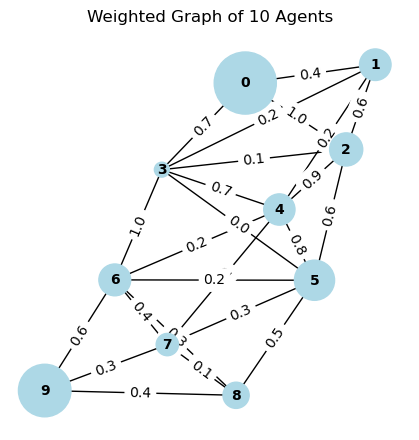

In [308]:
# Create the graph
Graph = nx.from_numpy_array(G, create_using=nx.Graph)  # Use nx.Graph for undirected

# Plot the graph
plt.figure(figsize=(4, 4))
pos = nx.spring_layout(Graph, k=4, iterations=600, seed=seed)  # Layout for positioning the nodes

# Draw nodes and edges
nx.draw(Graph, pos, with_labels=True, node_color="lightblue", node_size=c*2000, font_size=10, font_weight="bold")
nx.draw_networkx_edge_labels(Graph, pos, edge_labels={(i, j): f'{d["weight"]:.1f}' for i, j, d in Graph.edges(data=True)})

plt.title("Weighted Graph of 10 Agents")
plt.show()

## Training

### Single Global Model

In [218]:
np.random.seed(seed)
thetas_mono = np.random.rand(X_train_augmented.shape[1])
costs_train_mono = np.zeros((T))
costs_test_mono = np.zeros((T))

train_acc = np.zeros((T))
test_acc = np.zeros((T))

for i in range(T):
    thetas_mono = ml.stepForwardMono(thetas_mono, X_train_augmented, Y_train)
    costs_train_mono[i] = lr.cost(thetas_mono, X_train_augmented, Y_train)
    costs_test_mono[i] = lr.cost(thetas_mono, X_test_augmented, Y_test)

    train_acc[i] = lr.accuracy(thetas_mono, X_train_augmented, Y_train)
    test_acc[i] = lr.accuracy(thetas_mono, X_test_augmented, Y_test)

    if i % (T/10) == 0:
                print(f'Iteration {i} : Train: {costs_train_mono[i]:.4f} | Test: {costs_test_mono[i]:.4f}')

Iteration 0 : Train: 1.2286 | Test: 1.2075
Iteration 25 : Train: 0.4285 | Test: 0.4365
Iteration 50 : Train: 0.3654 | Test: 0.3740
Iteration 75 : Train: 0.3507 | Test: 0.3573
Iteration 100 : Train: 0.3459 | Test: 0.3510
Iteration 125 : Train: 0.3441 | Test: 0.3483
Iteration 150 : Train: 0.3434 | Test: 0.3470
Iteration 175 : Train: 0.3432 | Test: 0.3464
Iteration 200 : Train: 0.3430 | Test: 0.3461
Iteration 225 : Train: 0.3430 | Test: 0.3460


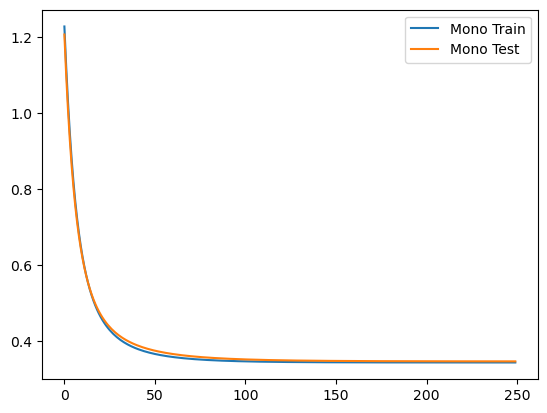

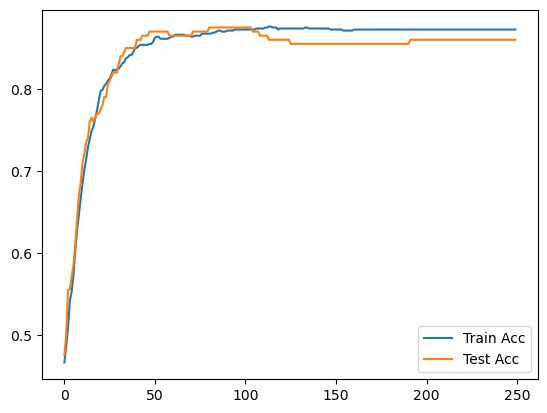

In [219]:
plt.plot(costs_train_mono, label="Mono Train")
plt.plot(costs_test_mono, label="Mono Test")
plt.legend()
plt.show()

plt.plot(train_acc, label="Train Acc")
plt.plot(test_acc, label="Test Acc")
plt.legend()
plt.show()

# util.plot_curves(num_agents, costs_train_agents_globalModel, costs_test_agents_globalModel, "Multiple Agents")

### Multiple agents

Agents dont share their models (perfectly private baseline)

In [220]:
np.random.seed(seed)
thetas_agents_alone = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_agents_alone = np.zeros((T, num_agents))
costs_test_agents_alone = np.zeros((T, num_agents))
costs_train_alone = np.zeros(T)
costs_test_alone = np.zeros(T)
acc_train_agents_alone = np.zeros((T, num_agents))
acc_test_agents_alone = np.zeros((T, num_agents))
acc_test_alone_maj = np.zeros(T)

print("Iter: Agents_Mean       | Total ")
for i in range(T):
    thetas_agents_alone = ml.stepForwardAlone(thetas_agents_alone, X_agent_augmented, Y_agent, num_agents)
    for j in range(num_agents):
            costs_train_agents_alone[i,j] = lr.cost(thetas_agents_alone[j], X_agent_augmented[j], Y_agent[j])
            costs_test_agents_alone[i,j] = lr.cost(thetas_agents_alone[j], X_test_augmented, Y_test)

            acc_train_agents_alone[i, j] = lr.accuracy(thetas_agents_alone[j], X_agent_augmented[j], Y_agent[j])
            acc_test_agents_alone[i, j] = lr.accuracy(thetas_agents_alone[j], X_test_augmented, Y_test)

    costs_train_alone[i] = lr.costDecentralized(thetas_agents_alone, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test_alone[i] = lr.costDecentralized(thetas_agents_alone, X_test_augmented, Y_test, num_agents, G, D, c, mu)
    acc_test_alone_maj[i] = lr.accuracyMajorityVote(num_agents, thetas_agents_alone, X_test_augmented, Y_test)

    if i % (T/10) == 0 :
        print(f'{i:3} : ({np.mean(costs_train_agents_alone[i]):.4f} , {np.mean(costs_test_agents_alone[i]):.4f}) | ({costs_train_alone[i]:.4f} , {costs_test_alone[i]:.4f})')

Iter: Agents_Mean       | Total 
  0 : (0.9549 , 1.1081) | (18.7957 , 18.0700)
 25 : (0.3431 , 0.5557) | (16.0130 , 15.7531)
 50 : (0.2656 , 0.5040) | (19.0875 , 18.8838)
 75 : (0.2381 , 0.4999) | (23.1163 , 22.9311)
100 : (0.2236 , 0.5072) | (27.2818 , 27.1057)
125 : (0.2144 , 0.5181) | (31.3741 , 31.2033)
150 : (0.2079 , 0.5302) | (35.3352 , 35.1680)
175 : (0.2031 , 0.5425) | (39.1553 , 38.9907)
200 : (0.1993 , 0.5545) | (42.8401 , 42.6774)
225 : (0.1961 , 0.5662) | (46.3989 , 46.2378)


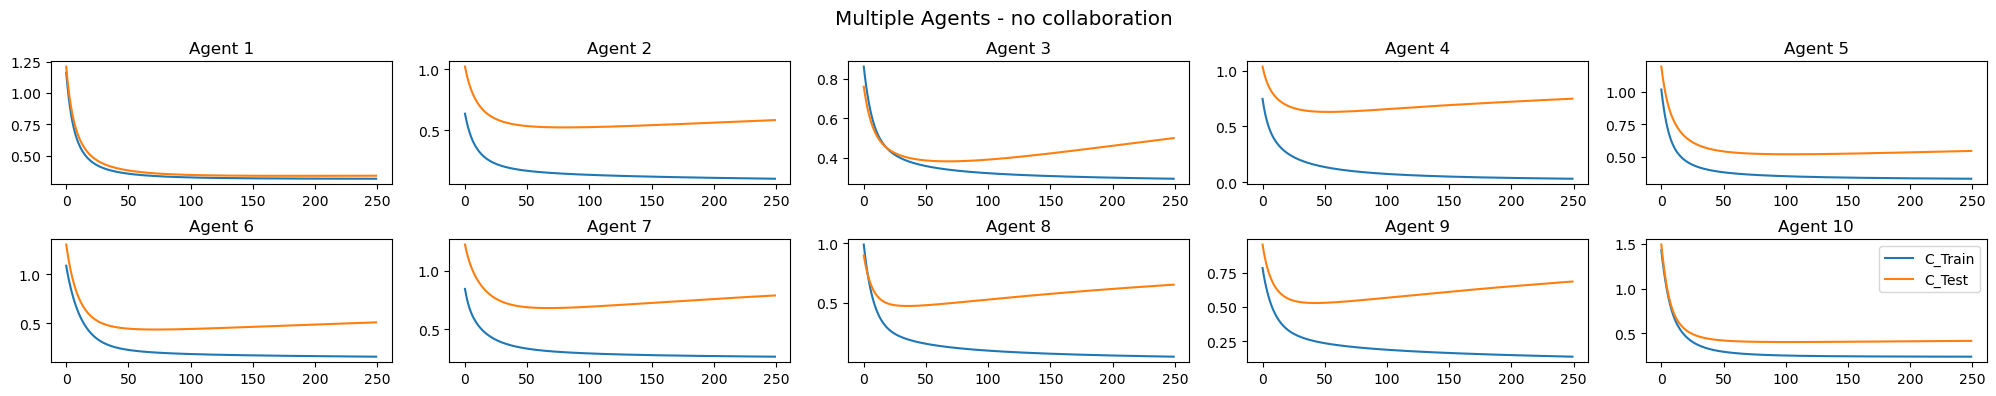

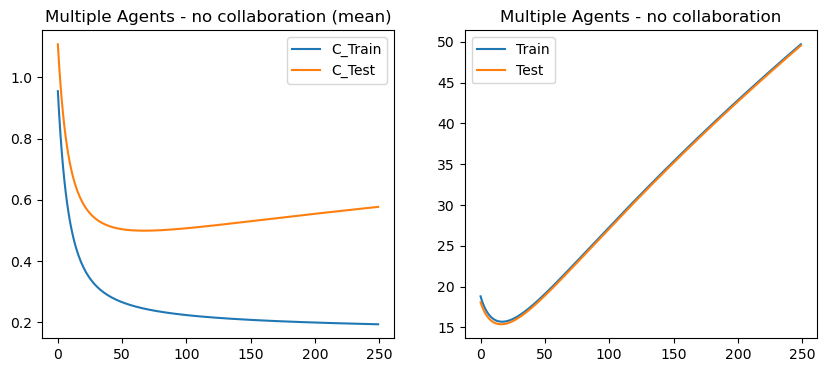

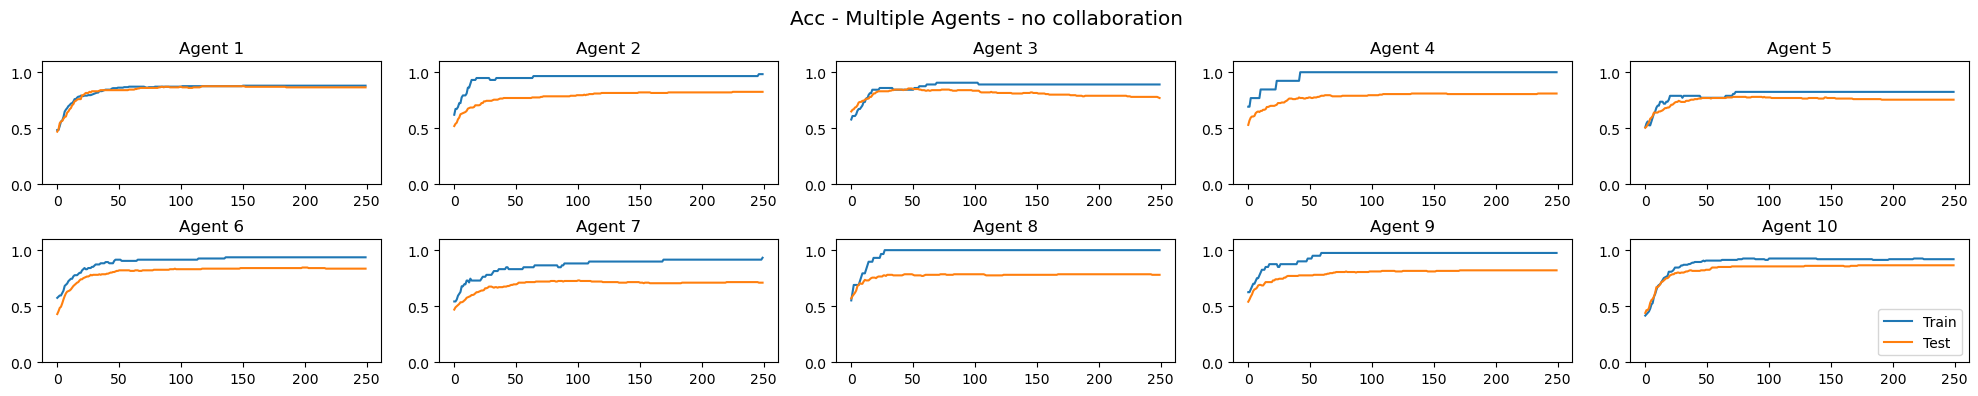

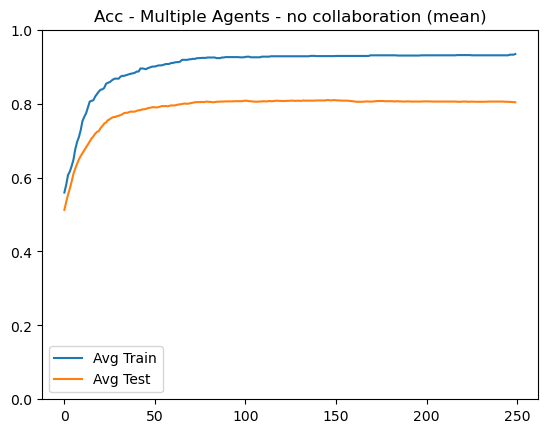

In [221]:
util.plot_curves(num_agents, costs_train_agents_alone, costs_test_agents_alone, costs_train_alone, costs_test_alone, "Multiple Agents - no collaboration")
util.plot_accuracy(num_agents, acc_train_agents_alone, acc_test_agents_alone, "Acc - Multiple Agents - no collaboration")

### Multiple agents

All agents do a step after each other in a naive queue and share their models

In [222]:
np.random.seed(seed)
thetas_agents = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_agents = np.zeros((T, num_agents))
costs_test_agents = np.zeros((T, num_agents))
costs_train = np.zeros(T)
costs_test = np.zeros(T)
acc_train_agents = np.zeros((T, num_agents))
acc_test_agents = np.zeros((T, num_agents))
acc_test_maj = np.zeros(T)

print("Iter: Agents_Mean       | Total ")
for i in range(T):
    thetas_agents = ml.stepForward(thetas_agents, X_agent_augmented, Y_agent, num_agents, mu, c, G, D)
    for j in range(num_agents):
            costs_train_agents[i,j] = lr.cost(thetas_agents[j], X_agent_augmented[j], Y_agent[j])
            costs_test_agents[i,j] = lr.cost(thetas_agents[j], X_test_augmented, Y_test)

            acc_train_agents[i,j] = lr.accuracy(thetas_agents[j], X_agent_augmented[j], Y_agent[j])
            acc_test_agents[i,j] = lr.accuracy(thetas_agents[j], X_test_augmented, Y_test)
    costs_train[i] = lr.costDecentralized(thetas_agents, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test[i] = lr.costDecentralized(thetas_agents, X_test_augmented, Y_test, num_agents, G, D, c, mu)
    acc_test_maj[i] = lr.accuracyMajorityVote(num_agents, thetas_agents, X_test_augmented, Y_test)
    if i % (T/10) == 0 :
        print(f'{i:3} : ({np.mean(costs_train_agents[i]):.4f} , {np.mean(costs_test_agents[i]):.4f}) | ({costs_train[i]:.4f} , {costs_test[i]:.4f})')

Iter: Agents_Mean       | Total 
  0 : (0.9915 , 1.1110) | (12.6230 , 11.8927)
 25 : (0.4102 , 0.4752) | (1.6351 , 1.3451)
 50 : (0.3440 , 0.3941) | (1.2043 , 0.9577)
 75 : (0.3280 , 0.3703) | (1.0922 , 0.8561)
100 : (0.3226 , 0.3605) | (1.0595 , 0.8269)
125 : (0.3206 , 0.3559) | (1.0529 , 0.8215)
150 : (0.3197 , 0.3536) | (1.0552 , 0.8242)
175 : (0.3194 , 0.3525) | (1.0603 , 0.8294)
200 : (0.3193 , 0.3519) | (1.0658 , 0.8349)
225 : (0.3192 , 0.3516) | (1.0709 , 0.8400)


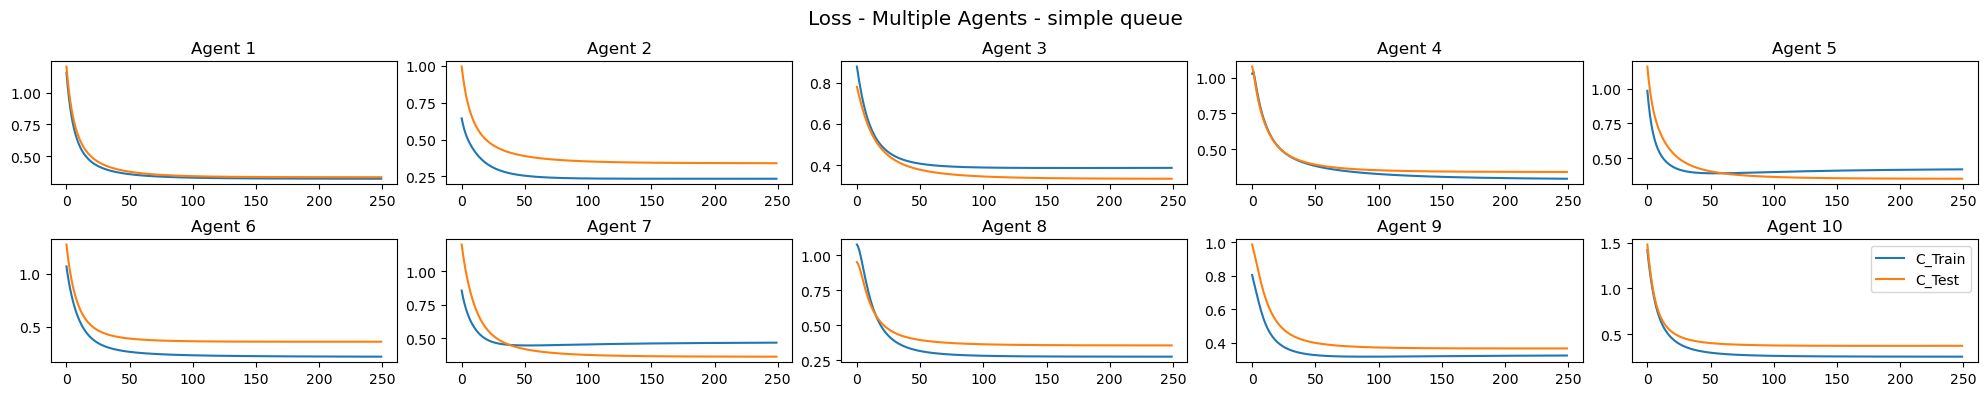

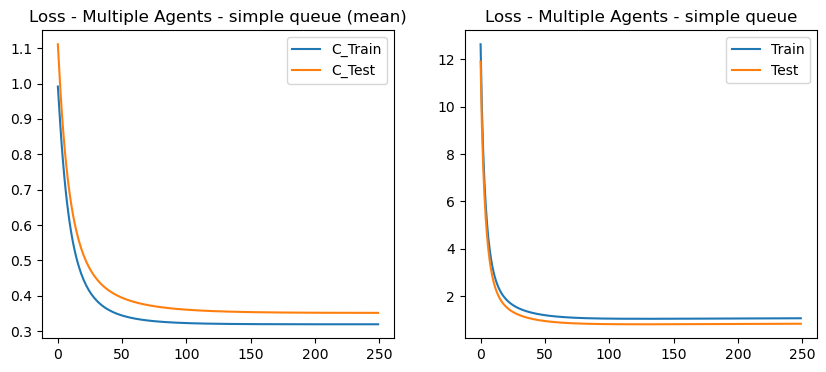

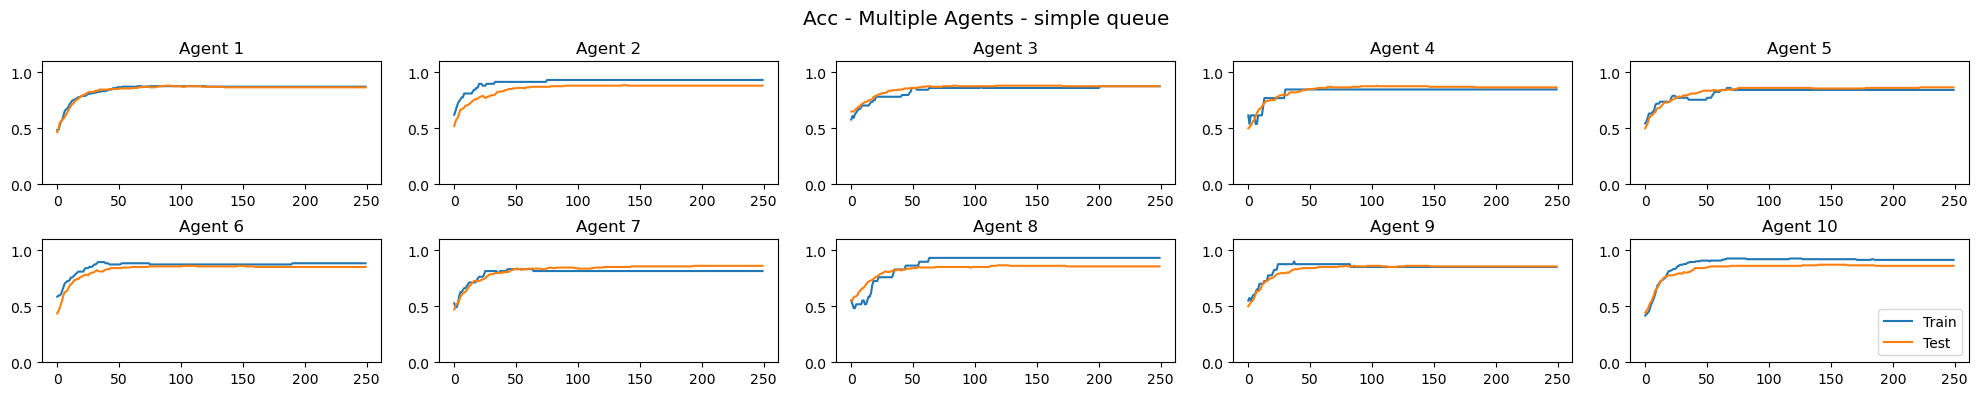

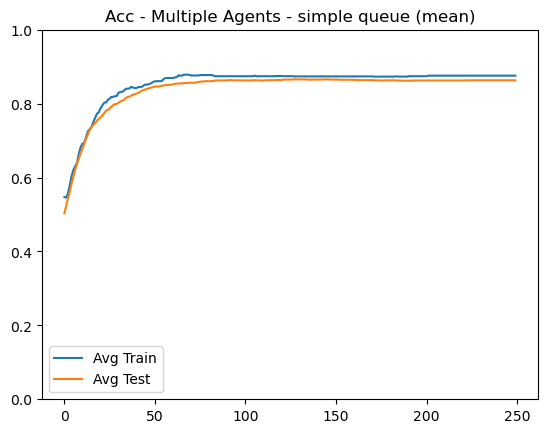

In [223]:
util.plot_curves(num_agents, costs_train_agents, costs_test_agents, costs_train, costs_test, "Loss - Multiple Agents - simple queue")
util.plot_accuracy(num_agents, acc_train_agents, acc_test_agents, "Acc - Multiple Agents - simple queue")

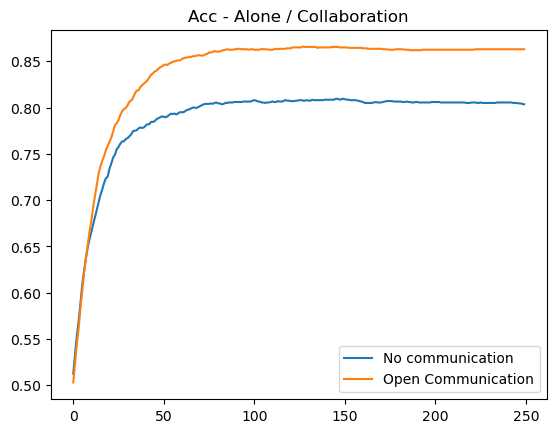

In [224]:
plt.plot(np.mean(acc_test_agents_alone, axis=1), label="No communication")
plt.plot(np.mean(acc_test_agents, axis=1), label="Open Communication")
#plt.plot(acc_test_maj, label="OpenCom MajVote")
plt.legend()
plt.title("Acc - Alone / Collaboration")
plt.show()

### Random drawing of Agents

randint with global quota

In [225]:
np.random.seed(seed)
tracking  = np.zeros(num_agents) # pour mesurer le nombre de fois que chaque agent passe
total_T = T*num_agents

thetas_agents_rand = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_rand = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_rand = np.zeros((total_T, num_agents))
costs_test_rand = np.zeros(total_T)
costs_train_rand = np.zeros(total_T)

acc_test_agents_rand = np.zeros((total_T, num_agents))               
acc_train_agents_rand = np.zeros((total_T, num_agents))


print("Iter: Agents_Mean       | Total ")
for i in range (total_T) :
    j = rd.randint(0, num_agents-1)
    tracking[j] += 1

    thetas_agents_rand = ml.stepForward_2(thetas_agents_rand, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D) 

    costs_train_agents_rand[i, j] = lr.cost(thetas_agents_rand[j], X_agent_augmented[j], Y_agent[j])
    costs_test_agents_rand[i, j] = lr.cost(thetas_agents_rand[j], X_test_augmented, Y_test)

    acc_train_agents_rand[i, j] = lr.accuracy(thetas_agents_rand[j], X_agent_augmented[j], Y_agent[j])
    acc_test_agents_rand[i, j] = lr.accuracy(thetas_agents_rand[j], X_test_augmented, Y_test)

    if i % 10 == 0:
        costs_train_rand[int(i/10)] = lr.costDecentralized(thetas_agents_rand, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_rand[int(i/10)] = lr.costDecentralized(thetas_agents_rand, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_rand[i]):.4f} , {np.mean(costs_test_agents_rand[i]):.4f}) | ({costs_train_rand[int(i/10)]:.4f} , {costs_test_rand[int(i/10)]:.4f})')

costs_train_agents_rand = util.reduce_cost_matrix(costs_train_agents_rand)
costs_test_agents_rand = util.reduce_cost_matrix(costs_test_agents_rand)
costs_train_rand = costs_train_rand[:T]
costs_test_rand = costs_test_rand[:T]

acc_train_agents_rand = util.reduce_cost_matrix(acc_train_agents_rand)
acc_test_agents_rand = util.reduce_cost_matrix(acc_test_agents_rand)

Iter: Agents_Mean       | Total 
  0 : (0.1157 , 0.1205) | (19.0752 , 18.3092)
 25 : (0.0467 , 0.0514) | (1.6677 , 1.3723)
 50 : (0.0355 , 0.0375) | (1.2391 , 0.9924)
 75 : (0.0336 , 0.0349) | (1.0988 , 0.8630)
100 : (0.0264 , 0.0378) | (1.0555 , 0.8227)
125 : (0.0260 , 0.0375) | (1.0447 , 0.8131)
150 : (0.0324 , 0.0335) | (1.0495 , 0.8184)
175 : (0.0303 , 0.0343) | (1.0554 , 0.8244)
200 : (0.0322 , 0.0333) | (1.0661 , 0.8353)
225 : (0.0276 , 0.0357) | (1.0692 , 0.8383)


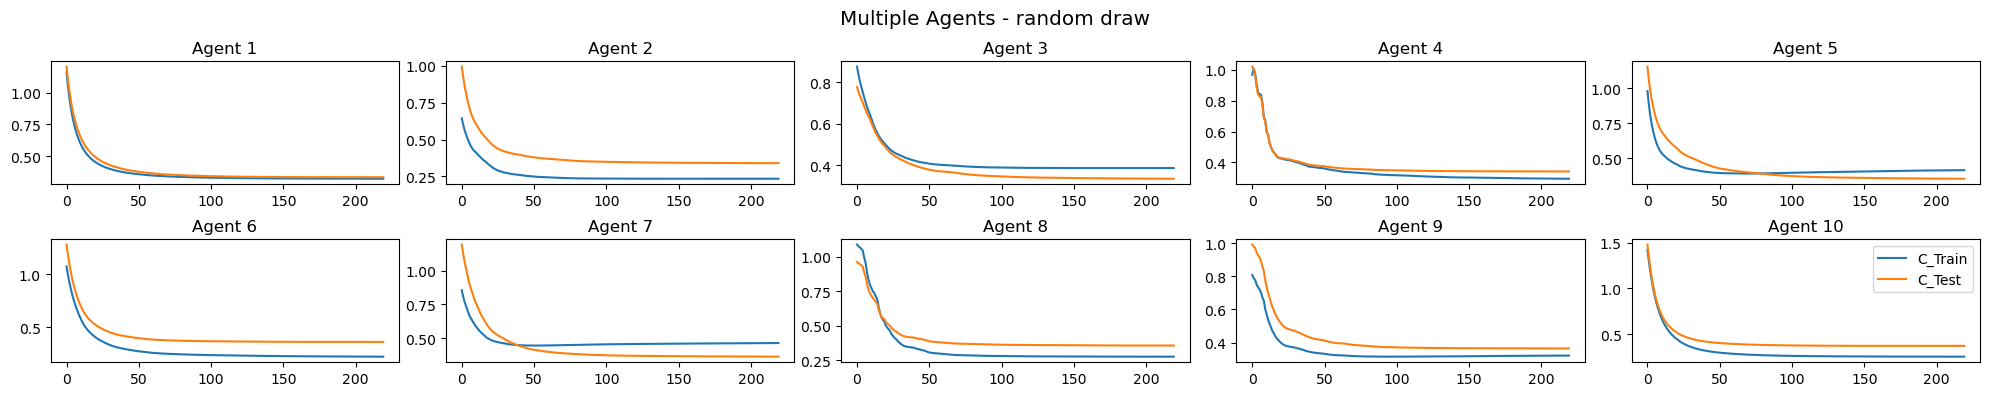

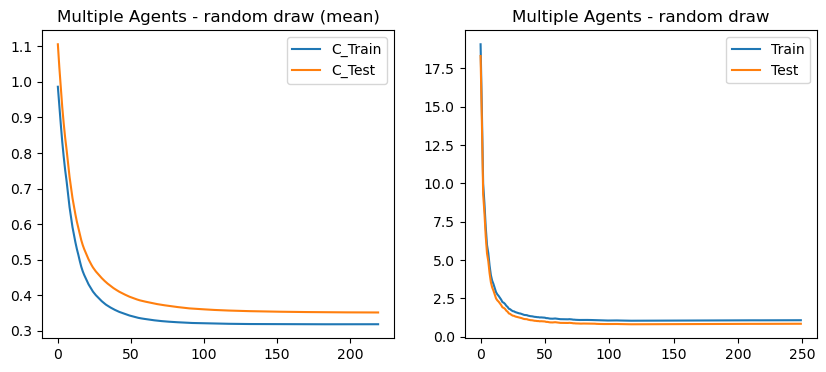

In [226]:
util.plot_curves(num_agents, costs_train_agents_rand, costs_test_agents_rand, costs_train_rand, costs_test_rand, "Multiple Agents - random draw")

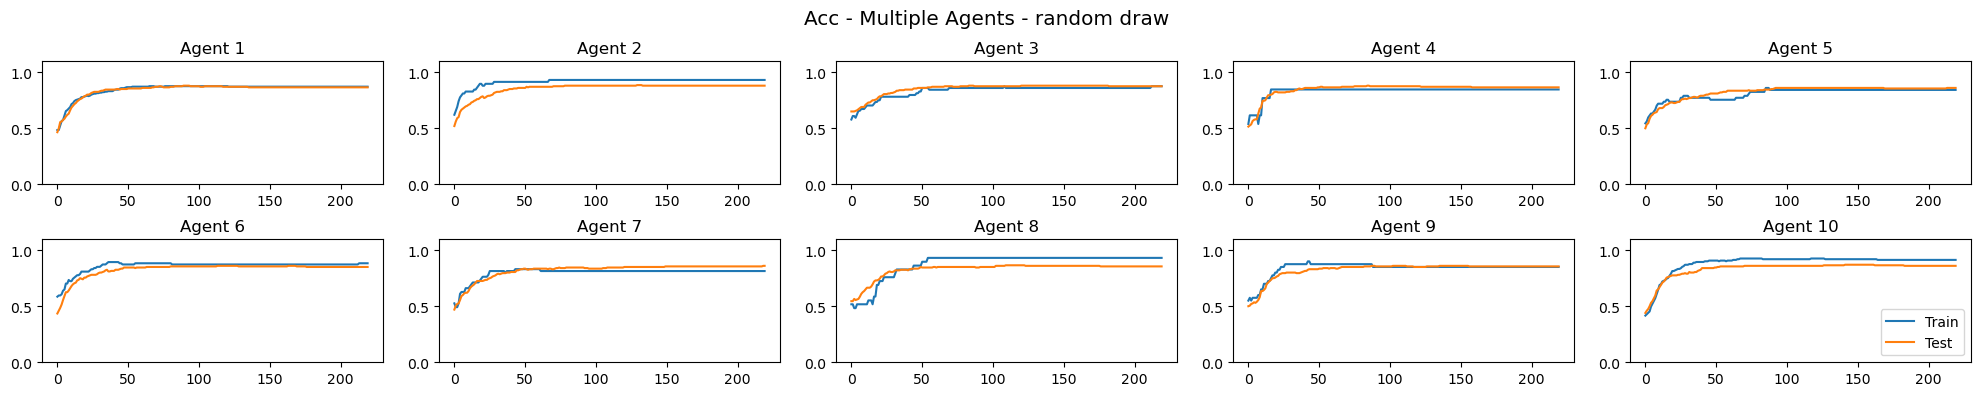

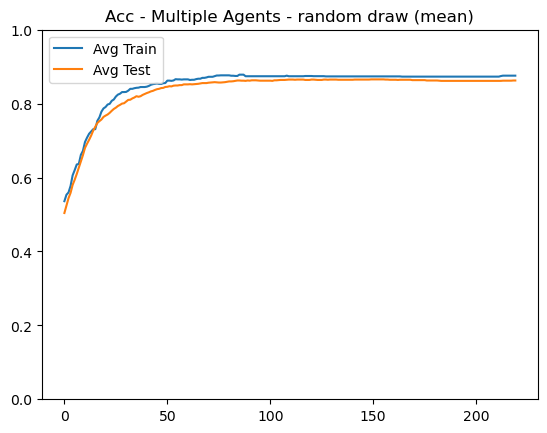

In [227]:
util.plot_accuracy(num_agents, acc_train_agents_rand, acc_test_agents_rand, "Acc - Multiple Agents - random draw")

### Weighted random draw of Agents

In [228]:
np.random.seed(seed)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_weigh = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_weigh = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_weigh = np.zeros((total_T, num_agents))
costs_test_weigh = np.zeros(total_T)
costs_train_weigh = np.zeros(total_T)


# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
print(coeffs_pond)
print("Iter: Agents_Mean       | Total ")

for i in range(total_T) :
    j = np.random.choice(num_agents, 1, p=coeffs_pond)[0]
    tracking[j] += 1

    thetas_agents_weigh = ml.stepForward_2(thetas_agents_weigh, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D) 

    costs_train_agents_weigh[i, j] = (lr.cost(thetas_agents_weigh[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_weigh[i, j] = (lr.cost(thetas_agents_weigh[j], X_test_augmented, Y_test))

    if i % 10 == 0:
        costs_train_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_weigh, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_weigh, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_weigh[i]):.4f} , {np.mean(costs_test_agents_weigh[i]):.4f}) | ({costs_train_weigh[int(i/10)]:.4f} , {costs_test_weigh[int(i/10)]:.4f})')

# costs_train_agents_weigh = util.reduce_cost_matrix(costs_train_agents_weigh)
# costs_test_agents_weigh = util.reduce_cost_matrix(costs_test_agents_weigh)

costs_train_agents_weigh_shifted = util.shift_non_zero_costs_to_front(costs_train_agents_weigh)
costs_test_agents_weigh_shifted = util.shift_non_zero_costs_to_front(costs_test_agents_weigh)

non_zero_counts = np.count_nonzero(costs_train_agents_weigh_shifted, axis=0)    
max_non_zero = np.max(non_zero_counts)
costs_train_weigh = costs_train_weigh[:max_non_zero]
costs_test_weigh = costs_test_weigh[:max_non_zero]

[0.28125 0.0725  0.08    0.01625 0.07125 0.1175  0.07375 0.03625 0.05
 0.20125]
Iter: Agents_Mean       | Total 
  0 : (0.0856 , 0.1197) | (18.9750 , 18.1854)
 25 : (0.0365 , 0.0460) | (2.1860 , 1.9148)
 50 : (0.0258 , 0.0386) | (1.5262 , 1.2885)
 75 : (0.0238 , 0.0370) | (1.3022 , 1.0708)
100 : (0.0319 , 0.0370) | (1.1929 , 0.9625)
125 : (0.0407 , 0.0359) | (1.1132 , 0.8827)
150 : (0.0256 , 0.0373) | (1.1041 , 0.8737)
175 : (0.0321 , 0.0334) | (1.0974 , 0.8668)
200 : (0.0255 , 0.0373) | (1.0937 , 0.8629)
225 : (0.0320 , 0.0334) | (1.0944 , 0.8635)


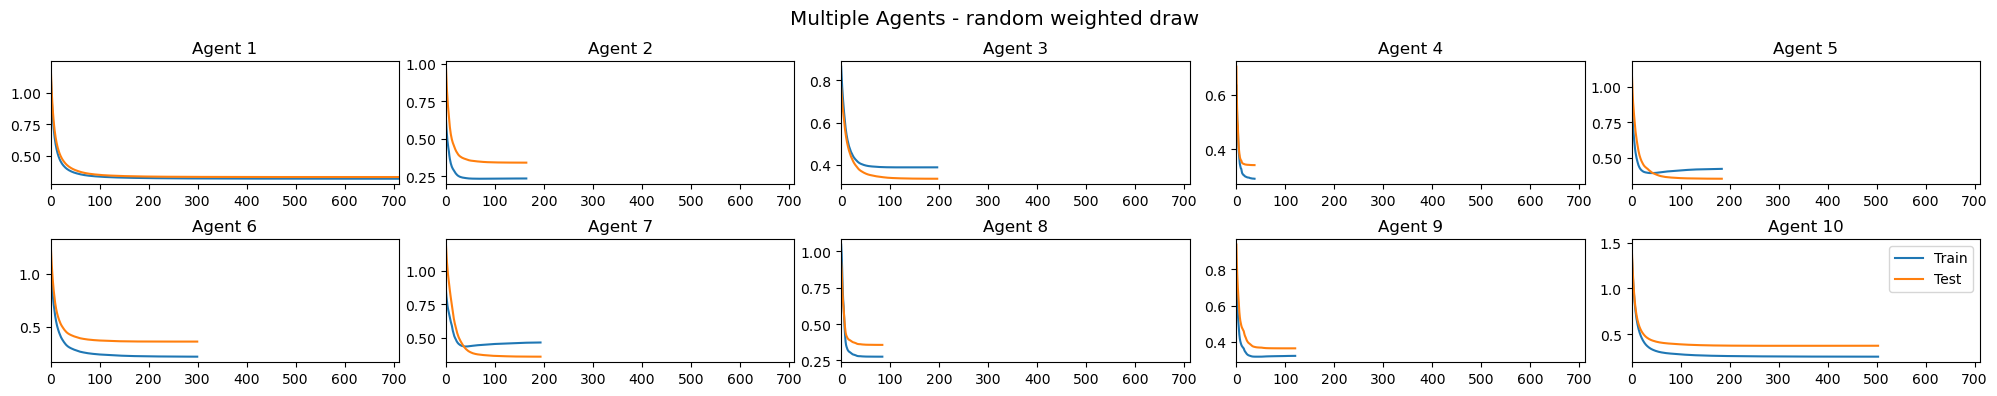

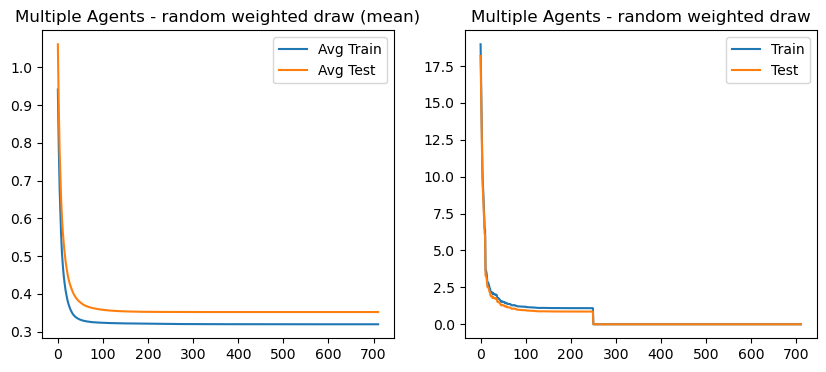

In [229]:
util.plot_curves_non_zero(num_agents, costs_train_agents_weigh_shifted, costs_test_agents_weigh_shifted, costs_train_weigh, costs_test_weigh, "Multiple Agents - random weighted draw")

## With Privacy

On fait avec $\delta = 0$ et $\epsilon_i(t_i) = \epsilon$

Si on veut partir du $\bar{\epsilon}$, on va utiliser $\delta$ et $\bar{\delta}$ tous nuls, et utiliser le théorème 1 (et la proposition 2 dans un deuxième temps) pour obtenir des epsilon.

Ici on peut avoir des $\bar{\epsilon}$ très élevés


In [230]:
epsilon = 0.05 # -> ici on a donc epsilon_barre = epsilon * T = 500
L_0 = 0.25

In [231]:
np.random.seed(seed)
thetas_private = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_private = np.zeros(T)
costs_test_private = np.zeros(T)

acc_train_private = np.zeros(T)
acc_test_private = np.zeros(T)
acc_test_private_maj = np.zeros(T)

for i in range(T):
    thetas_private = ml.stepForwardPrivate(thetas_private, X_agent_augmented, Y_agent, num_agents, mu, c, G, D, L_0, epsilon)
    costs_train_private[i] = lr.costDecentralized(thetas_private, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test_private[i] = lr.costDecentralized(thetas_private, X_test_augmented, Y_test, num_agents, G, D, c, mu)

    acc_train_private[i] = lr.accuracyAll(num_agents, thetas_private, X_agent_augmented, Y_agent)
    acc_test_private[i] = lr.accuracyAll(num_agents, thetas_private, [X_test_augmented for i in range(num_agents)], [Y_test for i in range(num_agents)])
    acc_test_private_maj[i] = lr.accuracyMajorityVote(num_agents, thetas_private, X_test_augmented, Y_test)
    
    if i % (T/10) == 0 :
        print(f'Iteration {i} : Train: {costs_train_private[i]:.4f} | Test: {costs_test_private[i]:.4f}')

Iteration 0 : Train: 23.6366 | Test: 22.8942
Iteration 25 : Train: 16.3787 | Test: 16.0670
Iteration 50 : Train: 16.9947 | Test: 16.7386
Iteration 75 : Train: 25.0774 | Test: 24.8094
Iteration 100 : Train: 25.2836 | Test: 25.0280
Iteration 125 : Train: 9.7476 | Test: 9.5118
Iteration 150 : Train: 16.3050 | Test: 16.0601
Iteration 175 : Train: 32.2536 | Test: 32.0104
Iteration 200 : Train: 9.7825 | Test: 9.5407
Iteration 225 : Train: 24.6761 | Test: 24.4281


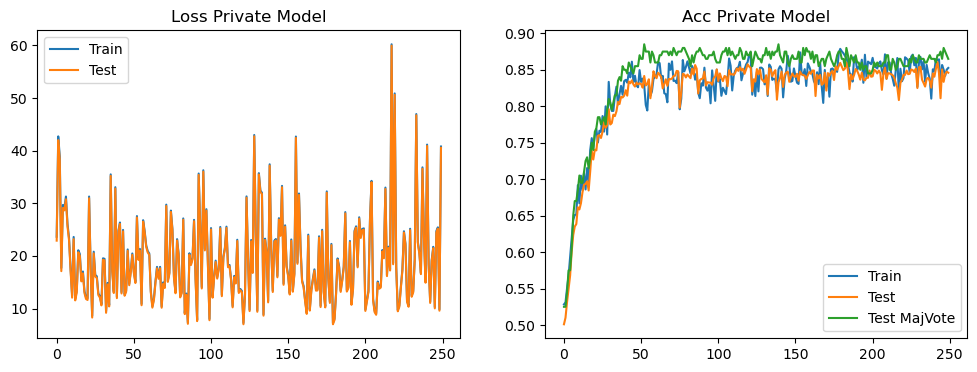

In [232]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(costs_train_private, label="Train")
plt.plot(costs_test_private, label="Test")
plt.legend()
plt.title("Loss Private Model")

plt.subplot(1, 2, 2)
plt.plot(acc_train_private, label="Train")
plt.plot(acc_test_private, label="Test")
plt.plot(acc_test_private_maj, label="Test MajVote")
plt.title("Acc Private Model")
plt.legend()
plt.show()

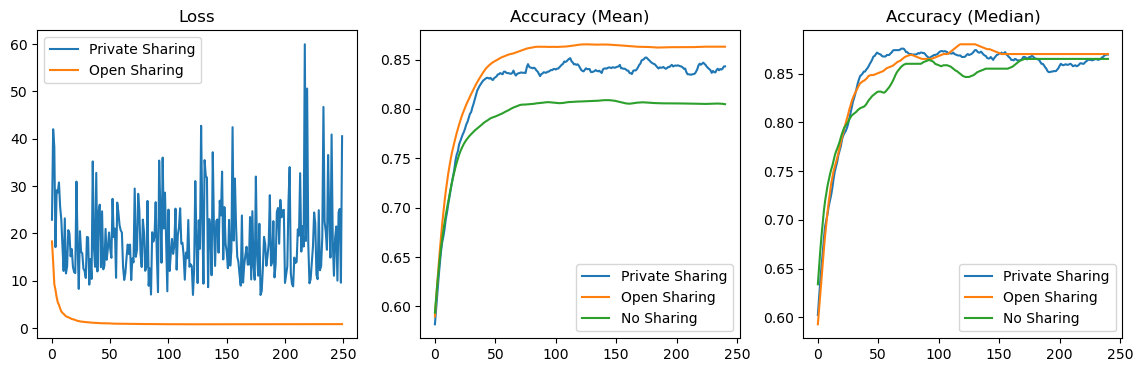

In [233]:
plt.figure(figsize=(14,4))
plt.subplot(1, 3, 1)
plt.plot(costs_test_private, label="Private Sharing")
plt.plot(costs_test_rand, label="Open Sharing")
#plt.plot(costs_test_alone, label="No Sharing")
plt.title("Loss")
plt.legend()

win_size = 10

plt.subplot(1, 3, 2)
plt.plot(util.moving_average(acc_test_private, win_size), label="Private Sharing")
#plt.plot(np.mean(acc_test_agents_rand, axis=1), label="Open Sharing (rand)")
plt.plot(util.moving_average(np.mean(acc_test_agents, axis=1), win_size), label="Open Sharing")
plt.plot(util.moving_average(np.mean(acc_test_agents_alone, axis=1), win_size), label="No Sharing")
#plt.plot(util.moving_average(acc_test_private_maj, win_size), label="P-Sha MajVote")
# plt.ylim(0, 1)
plt.title("Accuracy (Mean)")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(util.moving_average(acc_test_private_maj, win_size), label="Private Sharing")
#plt.plot(np.mean(acc_test_agents_rand, axis=1), label="Open Sharing (rand)")
plt.plot(util.moving_average(acc_test_maj, win_size), label="Open Sharing")
plt.plot(util.moving_average(acc_test_alone_maj, win_size), label="No Sharing")
# plt.ylim(0, 1)
plt.title("Accuracy (Median)")
plt.legend()
plt.show()

### Random drawing using constant epsilon

In [234]:
# epsilon = epsilon_barre / T # pour stepForwardPrivate normal

# il faut réestimer le epsilon_barre lorsque le nombre d'étapes d'entraînement pour un modèle n'est pas exactement T 

epsilon_barre = 50
L_0 = 0.25
epsilon = epsilon_barre / T

np.random.seed(seed)
tracking  = np.zeros(num_agents) # pour mesurer le nombre de fois que chaque agent passe
total_T = T*num_agents

thetas_agents_private_rand = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_private_rand = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_private_rand = np.zeros((total_T, num_agents))
costs_test_private_rand = np.zeros(total_T)
costs_train_private_rand = np.zeros(total_T)

acc_test_agents_private_rand = np.zeros((total_T, num_agents))               
acc_train_agents_private_rand = np.zeros((total_T, num_agents))


print("Iter: Agents_Mean       | Total ")
for i in range (total_T) :
    j = rd.randint(0, num_agents-1)
    tracking[j] += 1

    thetas_agents_private_rand = ml.stepForwardPrivate_2(thetas_agents_private_rand, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D, L_0, epsilon) 

    costs_train_agents_private_rand[i, j] = lr.cost(thetas_agents_private_rand[j], X_agent_augmented[j], Y_agent[j])
    costs_test_agents_private_rand[i, j] = lr.cost(thetas_agents_private_rand[j], X_test_augmented, Y_test)

    acc_train_agents_private_rand[i, j] = lr.accuracy(thetas_agents_private_rand[j], X_agent_augmented[j], Y_agent[j])
    acc_test_agents_private_rand[i, j] = lr.accuracy(thetas_agents_private_rand[j], X_test_augmented, Y_test)

    if i % 10 == 0:
        costs_train_private_rand[int(i/10)] = lr.costDecentralized(thetas_agents_private_rand, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_private_rand[int(i/10)] = lr.costDecentralized(thetas_agents_private_rand, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_private_rand[i]):.4f} , {np.mean(costs_test_agents_private_rand[i]):.4f}) | ({costs_train_private_rand[int(i/10)]:.4f} , {costs_test_private_rand[int(i/10)]:.4f})')

costs_train_agents_private_rand = util.reduce_cost_matrix(costs_train_agents_private_rand)
costs_test_agents_private_rand = util.reduce_cost_matrix(costs_test_agents_private_rand)
costs_train_private_rand = costs_train_private_rand[:T]
costs_test_private_rand = costs_test_private_rand[:T]

acc_train_agents_private_rand = util.reduce_cost_matrix(acc_train_agents_private_rand)
acc_test_agents_private_rand = util.reduce_cost_matrix(acc_test_agents_private_rand)

Iter: Agents_Mean       | Total 
  0 : (0.0804 , 0.0990) | (18.8775 , 18.0856)
 25 : (0.0488 , 0.0560) | (2.6013 , 2.2962)
 50 : (0.0327 , 0.0391) | (2.7585 , 2.5112)
 75 : (0.0273 , 0.0381) | (2.8528 , 2.6140)
100 : (0.0238 , 0.0354) | (1.6215 , 1.3870)
125 : (0.0275 , 0.0391) | (2.2656 , 2.0342)
150 : (0.0385 , 0.0336) | (2.2056 , 1.9733)
175 : (0.0235 , 0.0342) | (1.8240 , 1.5930)
200 : (0.0499 , 0.0398) | (2.4070 , 2.1729)
225 : (0.0333 , 0.0367) | (2.4785 , 2.2475)


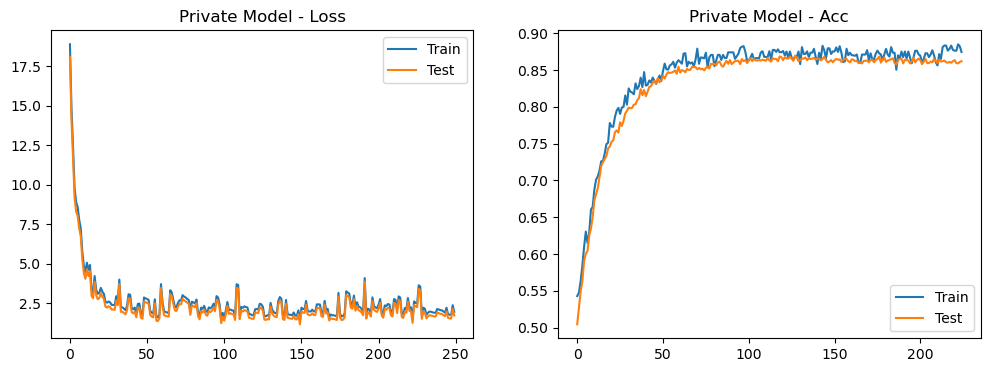

In [235]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(costs_train_private_rand, label="Train")
plt.plot(costs_test_private_rand, label="Test")
plt.title("Private Model - Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.mean(acc_train_agents_private_rand, axis=1), label="Train")
plt.plot(np.mean(acc_test_agents_private_rand, axis=1), label="Test")
plt.title("Private Model - Acc")
plt.legend()
plt.show()

### Weighted drawing with constant epsilons

In [236]:
# DEFINING EPSILON_BAR
epsilon_barre = 250
L_0 = 0.25

np.random.seed(seed)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_private_weigh = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_private_weigh = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_private_weigh = np.zeros((total_T, num_agents))

costs_test_private_weigh = np.zeros(total_T)
costs_train_private_weigh = np.zeros(total_T)


# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
# des probabilités, on déduit l'espérance du nombre d'itérations pour chaque agent
nb_iterations = np.zeros(num_agents)
for i in range (num_agents):
    nb_iterations = coeffs_pond * total_T


# puis les epsilon correspondants pour chaque agent
epsilon = np.zeros(num_agents)
for i in range(num_agents): 
    epsilon[i] = epsilon_barre / nb_iterations[i]
"""
print("Agent : Iterations  | epsilon | epsilon_barre")
for i in range(num_agents):
    print(f'{int(i):3} : ({nb_iterations[i]:.4f}) | ({epsilon[i]:.4f}) | ({epsilon[i]*nb_iterations[i]})')
"""
print()

print("Iter: Agents_Mean       | Total ")

for i in range(total_T) :
    j = np.random.choice(num_agents, 1, p=coeffs_pond)[0]
    tracking[j] += 1

    thetas_agents_private_weigh = ml.stepForwardPrivate_2(thetas_agents_private_weigh, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D, L_0, epsilon[j])

    costs_train_agents_private_weigh[i, j] = (lr.cost(thetas_agents_private_weigh[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_private_weigh[i, j] = (lr.cost(thetas_agents_private_weigh[j], X_test_augmented, Y_test))

    if i % 10 == 0:
        costs_train_private_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_private_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_private_weigh[i]):.4f} , {np.mean(costs_test_agents_private_weigh[i]):.4f}) | ({costs_train_private_weigh[int(i/10)]:.4f} , {costs_test_private_weigh[int(i/10)]:.4f})')

# costs_train_agents_weigh = util.reduce_cost_matrix(costs_train_agents_weigh)
# costs_test_agents_weigh = util.reduce_cost_matrix(costs_test_agents_weigh)

costs_train_agents_private_weigh_shifted = util.shift_non_zero_costs_to_front(costs_train_agents_private_weigh)
costs_test_agents_private_weigh_shifted = util.shift_non_zero_costs_to_front(costs_test_agents_private_weigh)

non_zero_counts = np.count_nonzero(costs_train_agents_private_weigh_shifted, axis=0)    
max_non_zero = np.max(non_zero_counts)
costs_train_private_weigh = costs_train_private_weigh[:T]
costs_test_private_weigh = costs_test_private_weigh[:T]


Iter: Agents_Mean       | Total 
  0 : (0.0856 , 0.1197) | (18.9714 , 18.1817)
 25 : (0.0282 , 0.0442) | (2.4107 , 2.1407)
 50 : (0.0330 , 0.0342) | (1.4740 , 1.2362)
 75 : (0.0266 , 0.0380) | (1.2929 , 1.0616)
100 : (0.0322 , 0.0335) | (1.1642 , 0.9337)
125 : (0.0305 , 0.0346) | (1.1212 , 0.8909)
150 : (0.0321 , 0.0334) | (1.1065 , 0.8762)
175 : (0.0322 , 0.0365) | (1.1039 , 0.8734)
200 : (0.0255 , 0.0373) | (1.0991 , 0.8683)
225 : (0.0320 , 0.0334) | (1.1013 , 0.8704)


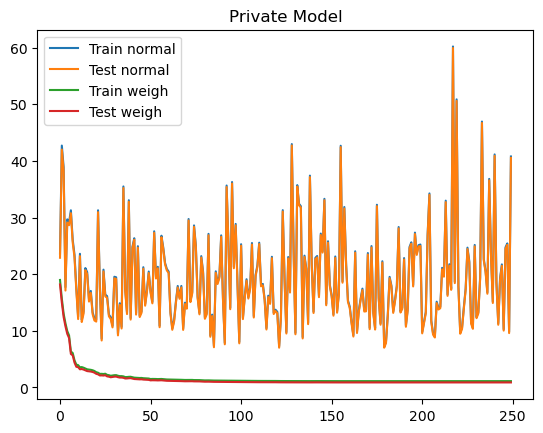

In [237]:
plt.plot(costs_train_private, label="Train normal")
plt.plot(costs_test_private, label="Test normal")
plt.plot(costs_train_private_weigh, label="Train weigh")
plt.plot(costs_test_private_weigh, label="Test weigh")
plt.title("Private Model")
plt.legend()
plt.show()

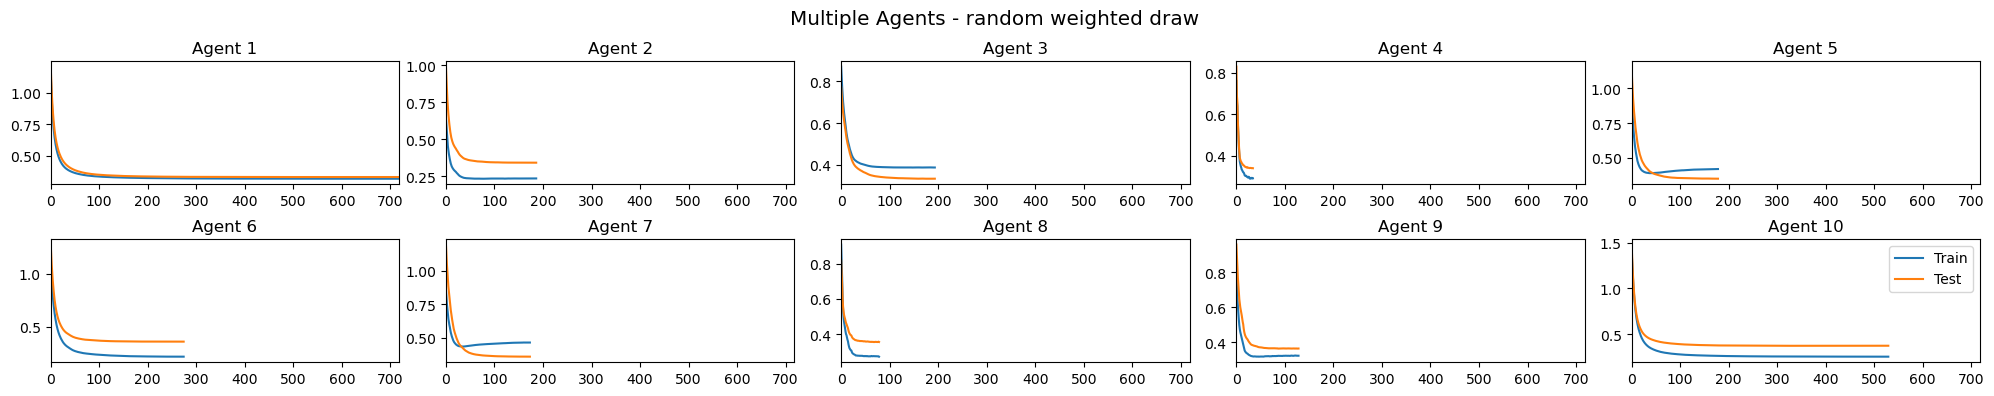

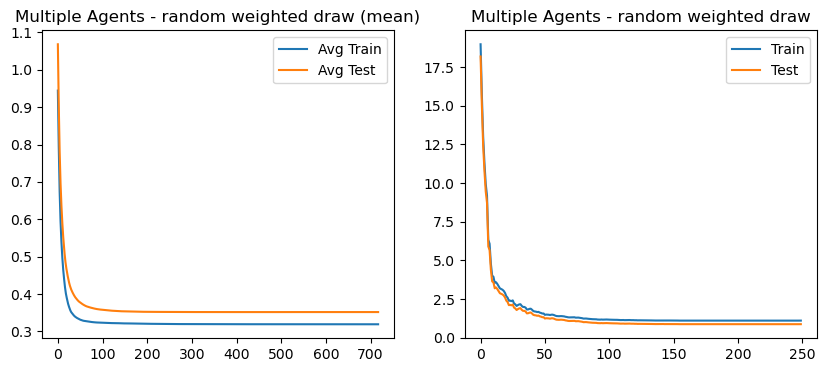

In [238]:
util.plot_curves_non_zero(num_agents, costs_train_agents_private_weigh_shifted, costs_test_agents_private_weigh_shifted, costs_train_private_weigh, costs_test_private_weigh, "Multiple Agents - random weighted draw")

### Weighted epsilons  implementing theorem 2 : optimal choice of epsilon

In [239]:
## constant for L2 regularization
lambda_ = 0.1

In [240]:
np.random.seed(seed)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_private_weigh_2 = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_private_weigh_2 = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_private_weigh_2 = np.zeros((total_T, num_agents))
costs_test_private_weigh_2 = np.zeros(total_T)
costs_train_private_weigh_2 = np.zeros(total_T)

acc_test_agents_private_weigh_2 = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
acc_train_agents_private_weigh_2 = np.zeros((total_T, num_agents))



# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
# on doit calculer grand C = 1 - sigma /(n*Lmax)
# sigma - strongly convex  : correspond à Ql
# Lmax : max Li, les Li sont les constantesblock lipschitz du gradient de Ql
sigma = 0.05                                                                                       # randomly chosen at the moment
Lmax = 20
epsilon_bar = 5
L_0 = 0.25

big_c = 1 - sigma/(num_agents*Lmax)
cube = big_c ** (1/3)
print(cube)
print()

lambdas = np.zeros(num_agents)
agent_choice = np.zeros(total_T)
agent_pre = np.zeros(total_T)
epsilons = np.zeros(total_T)

# we have to know in advance at which iterations each machine wakes up, and we compute our lambdas


for i in range(total_T) :
    j = np.random.choice(10, 1, p=coeffs_pond)[0]
    agent_choice[i] = j
    res = (cube-1) / ((cube ** total_T)-1) * (cube ** (i+1))
    agent_pre[i] = res
    lambdas[j] += res
    
for i in range(total_T) :
    epsilons[i] = agent_pre[i] * epsilon_bar / lambdas[int(agent_choice[i])]
    

count = 0
sum = 0
epsi_by_agent  = np.zeros(num_agents)
count_by_agent = np.zeros(num_agents)
first = np.zeros(num_agents)
last = np.zeros(num_agents)

for i in range(total_T):    
    if epsi_by_agent[int(agent_choice[i])] == 0:
        first[int(agent_choice[i])] = epsilons[i]
    last[int(agent_choice[i])] = epsilons[i]
    epsi_by_agent[int(agent_choice[i])] +=epsilons[i]
    count_by_agent[int(agent_choice[i])] += 1
    
for i in range(num_agents):
    epsi_by_agent[i] = epsi_by_agent[i] / count_by_agent[i]

rate_epsi = first - last


print(coeffs_pond)
print("Iter: Agents_Mean       | Total ")

for i in range(total_T) :
    j = int(agent_choice[i])
    epsi = epsilons[i]
    thetas_agents_private_weigh_2 = ml.stepForwardPrivate_2(thetas_agents_private_weigh_2, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D, L_0, epsi)

    costs_train_agents_private_weigh_2[i, j] = (lr.cost(thetas_agents_private_weigh_2[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_private_weigh_2[i, j] = (lr.cost(thetas_agents_private_weigh_2[j], X_test_augmented, Y_test))

    acc_train_agents_private_weigh_2[i, j] = lr.accuracy(thetas_agents_private_weigh_2[j], X_agent_augmented[j], Y_agent[j])
    acc_test_agents_private_weigh_2[i, j] = lr.accuracy(thetas_agents_private_weigh_2[j], X_test_augmented, Y_test)

    if i % 10 == 0:
        costs_train_private_weigh_2[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh_2, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_private_weigh_2[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh_2, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_private_weigh_2[i]):.4f} , {np.mean(costs_test_agents_private_weigh_2[i]):.4f}) | ({costs_train_private_weigh_2[int(i/10)]:.4f} , {costs_test_private_weigh_2[int(i/10)]:.4f})')

# costs_train_agents_weigh_2 = util.reduce_cost_matrix(costs_train_agents_weigh_2)
# costs_test_agents_weigh_2 = util.reduce_cost_matrix(costs_test_agents_weigh_2)

costs_train_agents_private_weigh_shifted_2 = util.shift_non_zero_costs_to_front(costs_train_agents_private_weigh_2)
costs_test_agents_private_weigh_shifted_2 = util.shift_non_zero_costs_to_front(costs_test_agents_private_weigh_2)

non_zero_counts = np.count_nonzero(costs_train_agents_private_weigh_shifted_2, axis=0)    
max_non_zero = np.max(non_zero_counts)
costs_train_private_weigh_2 = costs_train_private_weigh_2[:T]
costs_test_private_weigh_2 = costs_test_private_weigh_2[:T]

acc_train_agents_private_weigh_2 = util.reduce_cost_matrix(acc_train_agents_private_weigh_2)
acc_test_agents_private_weigh_2 = util.shift_non_zero_costs_to_front(acc_test_agents_private_weigh_2)[:T]

0.9999166597212575

[0.28125 0.0725  0.08    0.01625 0.07125 0.1175  0.07375 0.03625 0.05
 0.20125]
Iter: Agents_Mean       | Total 
  0 : (0.0827 , 0.1127) | (19.1567 , 18.3695)
 25 : (0.0485 , 0.0535) | (6.2313 , 5.9458)
 50 : (0.0253 , 0.0390) | (4.5990 , 4.3573)
 75 : (0.0244 , 0.0380) | (4.2692 , 4.0314)
100 : (0.0328 , 0.0366) | (3.5852 , 3.3460)
125 : (0.0383 , 0.0414) | (4.4115 , 4.1746)
150 : (0.0258 , 0.0371) | (5.3427 , 5.1050)
175 : (0.0323 , 0.0334) | (5.5616 , 5.3213)
200 : (0.0259 , 0.0382) | (6.6272 , 6.3862)
225 : (0.0322 , 0.0339) | (6.3354 , 6.0988)


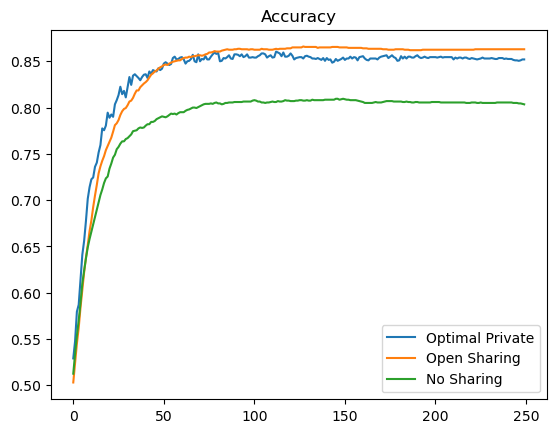

In [241]:
plt.plot(np.mean(util.propagate_last_value(acc_test_agents_private_weigh_2), axis=1), label="Optimal Private")
plt.plot(np.mean(acc_test_agents, axis=1), label="Open Sharing")
plt.plot(np.mean(acc_test_agents_alone, axis=1), label="No Sharing")
#plt.plot(acc_test_private, label="Private Sharing")
# plt.ylim(0, 1)
plt.title("Accuracy")
plt.legend()
plt.show()

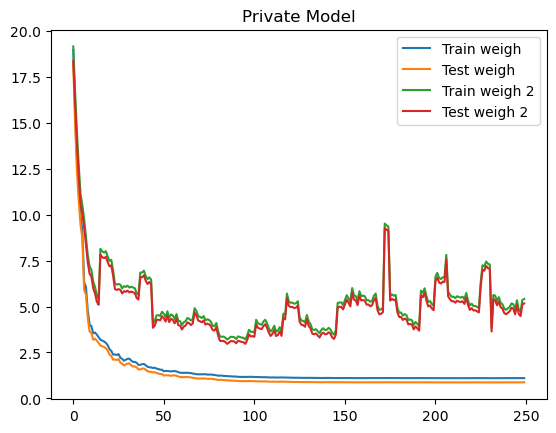

In [242]:
#plt.plot(costs_train_private, label="Train normal")
#plt.plot(costs_test_private, label="Test normal")
plt.plot(costs_train_private_weigh, label="Train weigh")
plt.plot(costs_test_private_weigh, label="Test weigh")
plt.plot(costs_train_private_weigh_2, label="Train weigh 2")
plt.plot(costs_test_private_weigh_2, label="Test weigh 2")
plt.title("Private Model")
plt.legend()
plt.show()